In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.utils import *
from tensorflow_model_optimization.sparsity import keras as sparsity
import tensorflow_model_optimization as tfmot
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import *
from statsmodels.tsa.stattools import *
from statsmodels.tsa.seasonal import *
from statsmodels.stats.diagnostic import *
from statsmodels.graphics.tsaplots import *
from sklearn.ensemble import RandomForestRegressor
import os
from scipy.stats import zscore
from scipy.fft import *
from scipy import *


2024-11-04 18:36:08.366543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 18:36:08.434800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 18:36:22.439621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [50]:
df = pd.read_csv("/mnt/d/CAIDA/dataset/Combined_Grouped_CAIDA.csv")
df.head()

,Flow Timeslot,Flow Packet Length,TCP Count,UDP Count,Flow Count,Timeslot Bitrate
0,10000,4256091,1334.0,659.0,1993,425.6091
1,20000,5239679,1379.0,673.0,2052,523.9679
2,30000,4530523,1387.0,677.0,2064,453.0523
3,40000,6721480,1270.0,648.0,1918,672.1480
4,50000,5304919,1342.0,674.0,2016,530.4919


In [51]:
train_val_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, val_df = train_test_split(train_val_df, test_size=0.125, shuffle=False)

def apply_transformations(df):
    df['Flow Timeslot_RollingMean'] = df['Flow Timeslot'].rolling(window=5).mean().fillna(0)
    df['TCP Count_RollingMean'] = df['TCP Count'].rolling(window=5).mean().fillna(0)
    df['UDP Count_RollingMean'] = df['UDP Count'].rolling(window=5).mean().fillna(0)
    df['Flow Count_RollingMean'] = df['Flow Count'].rolling(window=5).mean().fillna(0)
    df['Timeslot Bitrate_RollingMean'] = df['Timeslot Bitrate'].rolling(window=5).mean().fillna(0)

    df['Flow Timeslot_EMA'] = df['Flow Timeslot'].ewm(span=5).mean().fillna(0)
    df['TCP Count_EMA'] = df['TCP Count'].ewm(span=5).mean().fillna(0)
    df['UDP Count_EMA'] = df['UDP Count'].ewm(span=5).mean().fillna(0)
    df['Flow Count_EMA'] = df['Flow Count'].ewm(span=5).mean().fillna(0)
    df['Timeslot Bitrate_EMA'] = df['Timeslot Bitrate'].ewm(span=5).mean().fillna(0)

    df['Flow Timeslot_MovingStd'] = df['Flow Timeslot'].rolling(window=5).std().fillna(0)
    df['TCP Count_MovingStd'] = df['TCP Count'].rolling(window=5).std().fillna(0)
    df['UDP Count_MovingStd'] = df['UDP Count'].rolling(window=5).std().fillna(0)
    df['Flow Count_MovingStd'] = df['Flow Count'].rolling(window=5).std().fillna(0)
    df['Timeslot Bitrate_MovingStd'] = df['Timeslot Bitrate'].rolling(window=5).std().fillna(0)

    df['Flow Timeslot_MovingMedian'] = df['Flow Timeslot'].rolling(window=5).median().fillna(0)
    df['TCP Count_MovingMedian'] = df['TCP Count'].rolling(window=5).median().fillna(0)
    df['UDP Count_MovingMedian'] = df['UDP Count'].rolling(window=5).median().fillna(0)
    df['Flow Count_MovingMedian'] = df['Flow Count'].rolling(window=5).median().fillna(0)
    df['Timeslot Bitrate_MovingMedian'] = df['Timeslot Bitrate'].rolling(window=5).median().fillna(0)

    df['Flow Timeslot_Diff'] = df['Flow Timeslot'].diff().fillna(0)
    df['TCP Count_Diff'] = df['TCP Count'].diff().fillna(0)
    df['UDP Count_Diff'] = df['UDP Count'].diff().fillna(0)
    df['Flow Count_Diff'] = df['Flow Count'].diff().fillna(0)
    df['Timeslot Bitrate_Diff'] = df['Timeslot Bitrate'].diff().fillna(0)
    
    decomposition = seasonal_decompose(df['Timeslot Bitrate'], model='additive', period=5)
    df['Trend'] = decomposition.trend.fillna(0)
    
    return df

train_df = apply_transformations(train_df)
val_df = apply_transformations(val_df)
test_df = apply_transformations(test_df)

lags = 3

def apply_lags(df, lags=3):
    for lag in range(1, lags + 1):
        df[f'Flow Timeslot_Lag{lag}'] = df['Flow Timeslot'].shift(lag).fillna(0)
        df[f'TCP Count_Lag{lag}'] = df['TCP Count'].shift(lag).fillna(0)
        df[f'UDP Count_Lag{lag}'] = df['UDP Count'].shift(lag).fillna(0)
        df[f'Flow Count_Lag{lag}'] = df['Flow Count'].shift(lag).fillna(0)
        df[f'Timeslot Bitrate_Lag{lag}'] = df['Timeslot Bitrate'].shift(lag).fillna(0)
    
    return df

train_df = apply_lags(train_df)
val_df = apply_lags(val_df)
test_df = apply_lags(test_df)

def apply_acf_pacf(df, lags=3):
    timeslot_bitrate_acf = acf(df['Timeslot Bitrate'], nlags=lags)
    timeslot_bitrate_pacf = pacf(df['Timeslot Bitrate'], nlags=lags)
    
    for lag in range(1, lags + 1):
        df[f'Timeslot Bitrate_ACF{lag}'] = timeslot_bitrate_acf[lag]
        df[f'Timeslot Bitrate_PACF{lag}'] = timeslot_bitrate_pacf[lag]
    
    return df

train_df = apply_acf_pacf(train_df)
val_df = apply_acf_pacf(val_df)
test_df = apply_acf_pacf(test_df)

features = [
    'Flow Timeslot', 'TCP Count', 'UDP Count', 'Flow Count',
    'Flow Timeslot_RollingMean', 'TCP Count_RollingMean', 'UDP Count_RollingMean', 'Flow Count_RollingMean', 'Timeslot Bitrate_RollingMean',
    'Flow Timeslot_EMA', 'TCP Count_EMA', 'UDP Count_EMA', 'Flow Count_EMA', 'Timeslot Bitrate_EMA',
    'Flow Timeslot_MovingStd', 'TCP Count_MovingStd', 'UDP Count_MovingStd', 'Flow Count_MovingStd', 'Timeslot Bitrate_MovingStd',
    'Flow Timeslot_MovingMedian', 'TCP Count_MovingMedian', 'UDP Count_MovingMedian', 'Flow Count_MovingMedian', 'Timeslot Bitrate_MovingMedian',
    'Flow Timeslot_Diff', 'TCP Count_Diff', 'UDP Count_Diff', 'Flow Count_Diff', 'Timeslot Bitrate_Diff',
    'Trend'
] + [f'Flow Timeslot_Lag{lag}' for lag in range(1, lags + 1)] + [f'TCP Count_Lag{lag}' for lag in range(1, lags + 1)] + [f'UDP Count_Lag{lag}' for lag in range(1, lags + 1)] + [f'Flow Count_Lag{lag}' for lag in range(1, lags + 1)] + [f'Timeslot Bitrate_Lag{lag}' for lag in range(1, lags + 1)] + [f'Timeslot Bitrate_ACF{lag}' for lag in range(1, lags + 1)] + [f'Timeslot Bitrate_PACF{lag}' for lag in range(1, lags + 1)]

X_train = train_df[features].values
Y_train = train_df['Timeslot Bitrate'].values
X_val = val_df[features].values
Y_val = val_df['Timeslot Bitrate'].values
X_test = test_df[features].values
Y_test = test_df['Timeslot Bitrate'].values

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1)).flatten()
Y_val_scaled = scaler_Y.transform(Y_val.reshape(-1, 1)).flatten()
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1)).flatten()


#Determined optimal features using a RF Regressor
indices = [13, 28, 42, 18, 43, 1, 8, 44, 3, 23, 2, 29, 15, 17, 16, 39, 25, 36, 41, 27,
           40, 26, 35, 33, 38, 37, 34, 12, 10, 11, 7, 21, 5, 22, 6, 20, 30, 19, 32, 31,
           9, 4, 0, 24, 14, 47, 45, 49, 50, 46, 48]
k = 15
top_k_indices = indices[:k]
top_k_features = np.array(features)[top_k_indices]

X_train_selected = X_train_scaled[:, top_k_indices]
X_val_selected = X_val_scaled[:, top_k_indices]
X_test_selected = X_test_scaled[:, top_k_indices]

def create_sequences(X, Y, n_past, n_future):
    X_sequences, Y_sequences = [], []
    for i in range(n_past, len(X) - n_future + 1):
        X_sequence = X[i - n_past:i, :]
        Y_sequence = Y[i + n_future - 1]
        X_sequences.append(X_sequence)
        Y_sequences.append(Y_sequence)
    return np.array(X_sequences), np.array(Y_sequences)

n_past = 5
n_future = 1

X_train, Y_train = create_sequences(X_train_selected, Y_train_scaled, n_past, n_future)
X_val, Y_val = create_sequences(X_val_selected, Y_val_scaled, n_past, n_future)
X_test, Y_test = create_sequences(X_test_selected, Y_test_scaled, n_past, n_future)


In [4]:
model = Sequential([
    LSTM(32, activation='leaky_relu', kernel_initializer='he_normal', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LayerNormalization(),
    Dropout(0.2),

    LSTM(64, activation='leaky_relu', kernel_initializer='he_normal', return_sequences=True),
    LayerNormalization(),
    Dropout(0.2),

    LSTM(128, activation='leaky_relu', kernel_initializer='he_normal', return_sequences=False),
    LayerNormalization(),
    Dropout(0.2),

    Dense(64, activation='leaky_relu', kernel_initializer='he_normal'),
    Dropout(0.2),

    Dense(32, activation='leaky_relu', kernel_initializer='he_normal'),
    Dropout(0.2),

    Dense(1, activation='tanh', kernel_initializer='lecun_normal', kernel_regularizer='l2')
])

optimizer = Adam(clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

model.summary()

2024-11-04 18:37:00.440886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-04 18:37:00.463208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-04 18:37:00.463269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-04 18:37:00.465513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-04 18:37:00.465567: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 32)          │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 5, 32)          │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 5, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,609 (549.25 KB)

 Trainable params: 140,609 (549.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
filepath = '/mnt/d/CAIDA/new/LSTM_new.keras'

checkpoint = ModelCheckpoint(
    filepath=filepath, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
mode='min', 
patience=10, 
restore_best_weights=True, 
verbose=1)

In [34]:
history = model.fit(X_train, 
    Y_train, 
    epochs=100,
    batch_size=16384, 
    callbacks=[checkpoint, early_stopping], 
    validation_data=(X_test, Y_test), 
    verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 0.3260 - mse: 0.3151
Epoch 1: val_loss improved from inf to 0.02465, saving model to /mnt/d/CAIDA/new/LSTM_new.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 627ms/step - loss: 0.3211 - mse: 0.3103 - val_loss: 0.0247 - val_mse: 0.0144
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0868 - mse: 0.0768
Epoch 2: val_loss did not improve from 0.02465
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0850 - mse: 0.0749 - val_loss: 0.0407 - val_mse: 0.0313
Epoch 3/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0388 - mse: 0.0295
Epoch 3: val_loss did not improve from 0.02465
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0385 - mse: 0.0292 - val_loss: 0.0256 - val_mse: 0.0167
Epoch 4/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0288 - mse: 0.0200
Epoch 4: val_loss improved from 0.02465 to 0.02402, saving model to /mnt/d/CAIDA/new/LSTM_new.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0287 - mse: 0.0

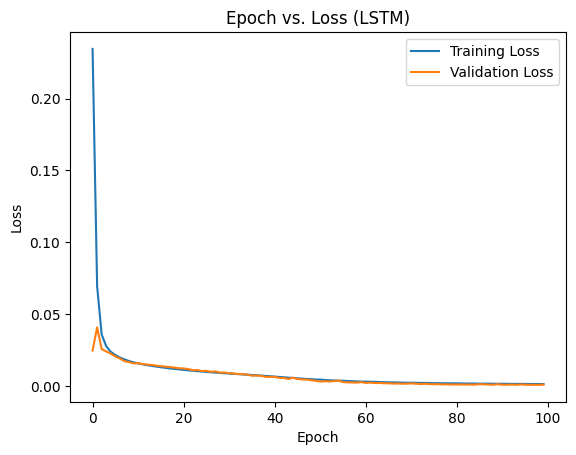

In [35]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(training_loss))

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss (LSTM)')

plt.legend()

plt.show()

1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


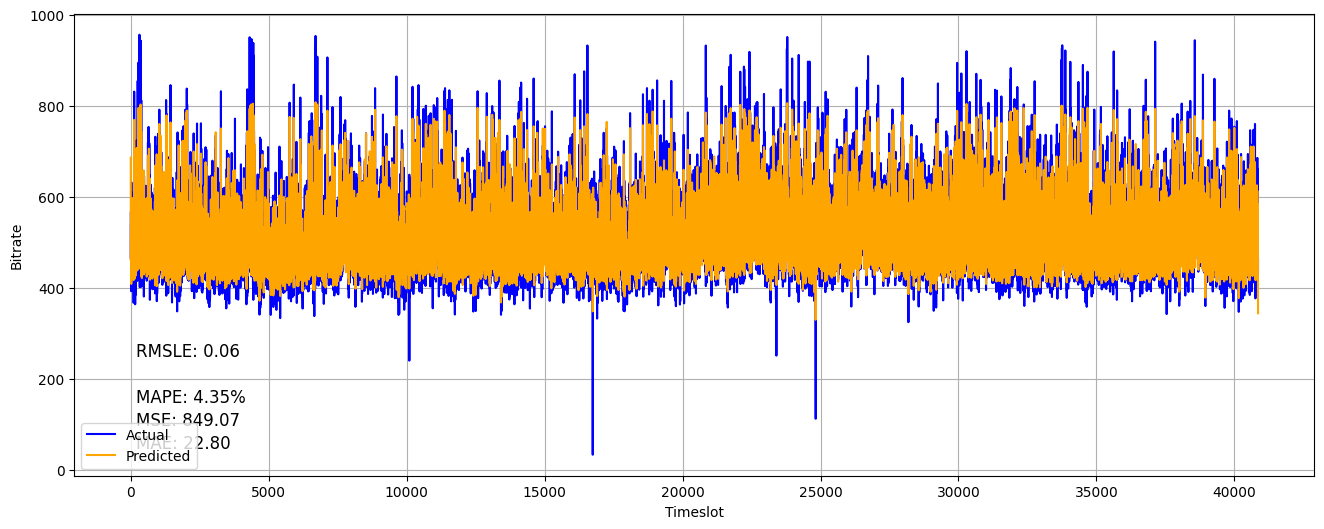

-15.03629994640964

In [36]:
#ensemble_model = load_model('/mnt/d/CAIDA/LSTM.keras')

predictions = model.predict(X_val)

predictions_original = scaler_Y.inverse_transform(predictions).flatten()
Y_val_original = scaler_Y.inverse_transform(Y_val.reshape(-1, 1)).flatten()

mae = mean_absolute_error(Y_val_original, predictions_original)
mse = mean_squared_error(Y_val_original, predictions_original)
mape = np.mean(np.abs((Y_val_original - predictions_original) / Y_val_original)) * 100
log_y_val = np.log1p(Y_val_original)
log_predictions = np.log1p(predictions_original)
rmsle = np.sqrt(np.mean((log_predictions - log_y_val) ** 2))
mfe = np.mean(predictions_original - Y_val_original)

plt.figure(figsize=(16, 6))
plt.plot(Y_val_original, label='Actual', color='blue')
plt.plot(predictions_original, label='Predicted', color='orange')

plt.xlabel('Timeslot')
plt.ylabel('Bitrate')
plt.legend()

plt.text(0.05, 0.05, f'MAE: {mae:.2f}', ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.05, 0.1, f'MSE: {mse:.2f}', ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.05, 0.15, f'MAPE: {mape:.2f}%', ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.05, 0.25, f'RMSLE: {rmsle:.2f}', ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=12)


plt.grid(True)
plt.show()
mfe

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 583ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0039 - val_mse: 0.0038
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0012 - val_mse: 0.0012
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Pruning percentile 10 -- MAE: 25.4692, MSE: 1110.2153, MAPE: 4.97%


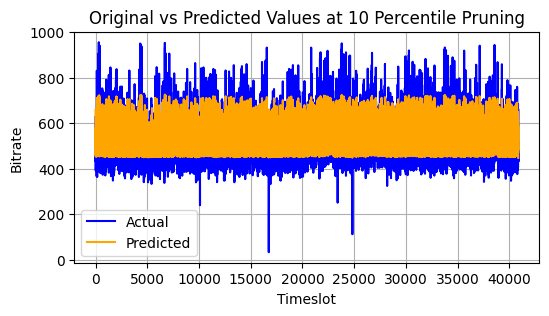

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0041 - mse: 0.0040 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0012 - val_mse: 0.0012
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 25 -- MAE: 24.8133, MSE: 1085.8539, MAPE: 4.89%


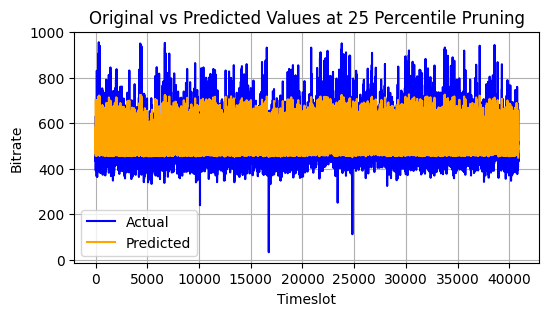

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0052 - val_mse: 0.0051
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0051 - val_mse: 0.0051
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 50 -- MAE: 49.8491, MSE: 4738.2997, MAPE: 9.37%


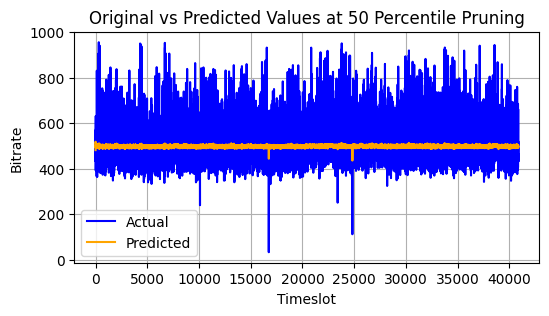

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0052 - val_mse: 0.0052
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 75 -- MAE: 50.4381, MSE: 4840.4741, MAPE: 9.47%


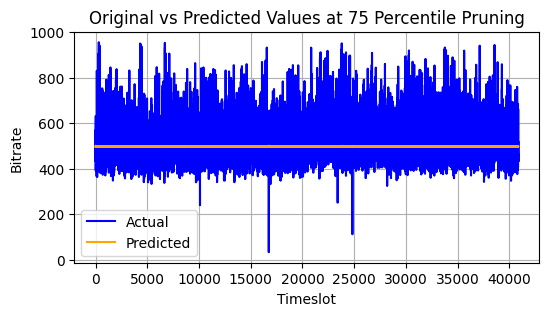

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0052 - val_mse: 0.0052
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 90 -- MAE: 50.3864, MSE: 4817.6775, MAPE: 9.48%


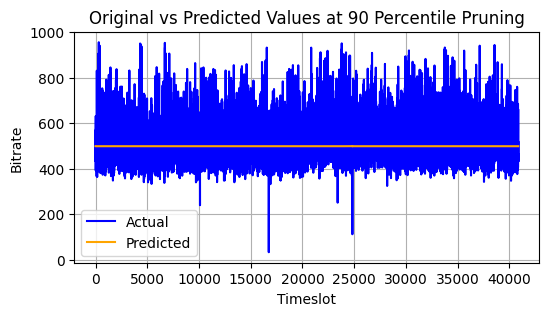

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0050 - val_mse: 0.0050
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 95 -- MAE: 50.0164, MSE: 4648.7007, MAPE: 9.53%


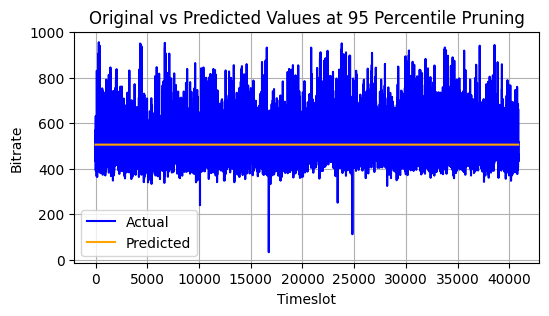

Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0052 - val_mse: 0.0051
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0051 - val_mse: 0.0051
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Pruning percentile 99 -- MAE: 50.0769, MSE: 4703.4212, MAPE: 9.50%


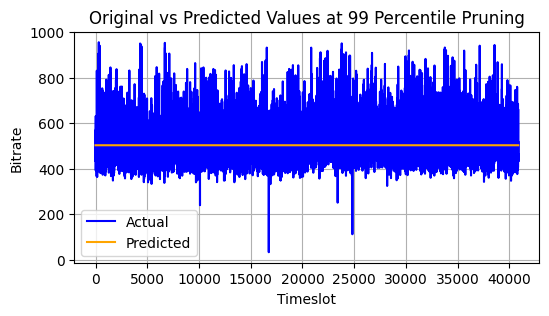

In [49]:
model = load_model('/mnt/d/CAIDA/new/LSTM_new.keras')

percentiles = [10, 25, 50, 75, 90, 95, 99]

pruned_weight_test_losses = []
pruned_weight_test_accuracies = []
pruned_weight_mae = []
pruned_weight_mse = []
pruned_weight_mape = []
pruned_weight_sparse_timings = []
pruned_weight_timings = []
model_sizes = []
parameter_counts = []
weights_to_freeze = []

def freeze_weights(weights_to_freeze, model):
    for layer in model.layers:
        for weight in layer.weights:
            for frozen_weight in weights_to_freeze:
                if tf.reduce_all(tf.equal(weight.shape, frozen_weight.shape)):
                    weight.assign(tf.zeros_like(weight))
                    break

for percentile in percentiles:
    pruned_weights = []
    for weights in model.get_weights():
        weights_np = np.array(weights)
        critical_value = np.percentile(np.abs(weights_np), percentile)
        pruned_weights_np = np.where(np.abs(weights_np) < critical_value, 0, weights_np)
        pruned_weights.append(pruned_weights_np)

        zeroed_weights = np.where(pruned_weights_np == 0, weights_np, 0)
        weights_to_freeze.append(zeroed_weights)
    
    model.set_weights(pruned_weights)
    freeze_weights(weights_to_freeze, model)
    history = model.fit(X_train, 
    Y_train, 
    epochs=2,
    batch_size=16384, 
    callbacks=[checkpoint], 
    validation_data=(X_test, Y_test), 
    verbose=1)
    
    predictions = model.predict(X_val)
    predictions_original = scaler_Y.inverse_transform(predictions).flatten()
    Y_val_original = scaler_Y.inverse_transform(Y_val.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(Y_val_original, predictions_original)
    mse = mean_squared_error(Y_val_original, predictions_original)
    mape = np.mean(np.abs((Y_val_original - predictions_original) / Y_val_original)) * 100
    
    pruned_weight_mae.append(mae)
    pruned_weight_mse.append(mse)
    pruned_weight_mape.append(mape)
    
    print(f"Pruning percentile {percentile} -- MAE: {mae:.4f}, MSE: {mse:.4f}, MAPE: {mape:.2f}%")
    
    plt.figure(figsize=(6, 3))
    plt.plot(Y_val_original, label='Actual', color='blue')
    plt.plot(predictions_original, label='Predicted', color='orange')
    plt.xlabel('Timeslot')
    plt.ylabel('Bitrate')
    plt.title(f'Original vs Predicted Values at {percentile} Percentile Pruning')
    plt.legend()
    plt.grid(True)
    plt.show()

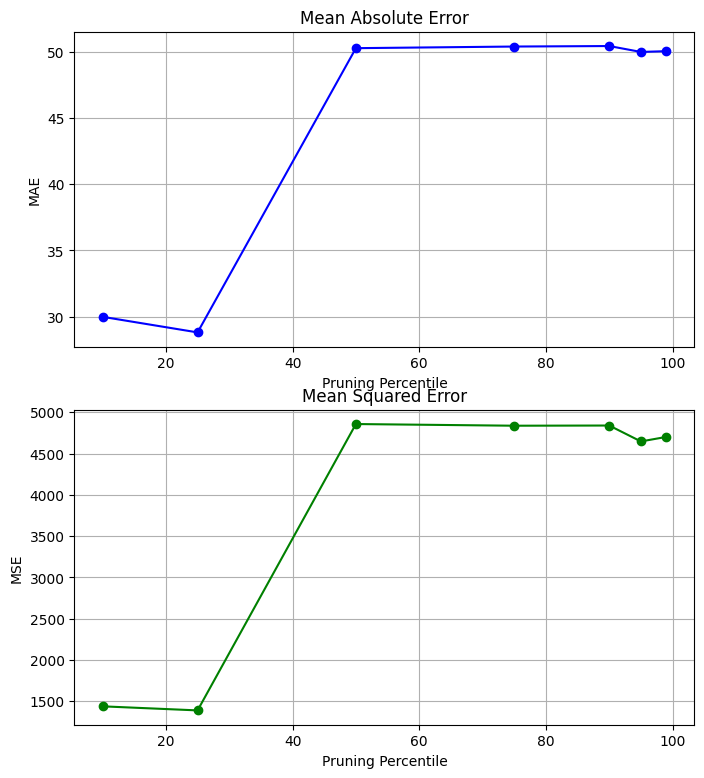

In [42]:
plt.figure(figsize=(8, 9))

plt.subplot(2, 1, 1)
plt.plot(percentiles, pruned_weight_mae, label='MAE', marker='o', color='b')
plt.xlabel('Pruning Percentile')
plt.ylabel('MAE')
plt.title('Mean Absolute Error')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(percentiles, pruned_weight_mse, label='MSE', marker='o', color='g')
plt.xlabel('Pruning Percentile')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.grid(True)